In [1]:
%matplotlib inline
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.fftpack import fft
import krotov
import scipy
from jupyterthemes import jtplot
jtplot.style(theme='solarizedl')
import os

F:\Anaconda\lib\site-packages\qutip\__init__.py:83: UserWarning: Old version of Cython detected: needed 0.29.20, got 0.29.13.
  .format(_cy_require, _Cython.__version__)


In [76]:
class STIRAP():
    def __init__(self,SP,Omega_S,Omega_P,E1,E2,E3,T,t1,t2,Δ=0,Gamma=0,delta=0):
        self.SP = SP
        self.Ω_S = Omega_S
        self.Ω_P = Omega_P
        self.E1 = E1
        self.E2 = E2
        self.E3 = E3
        self.T = T
        self.t1 = t1
        self.t2 = t2
        self.Δ = Δ - (1j*Gamma)
        self.efficiency = 0
        self.delta = delta
    
    def Omega_P1(self,t, args):
        """Guess for the real part of the pump pulse"""
        Ω0 = self.Ω_P
        if self.SP:
            return Ω0 * krotov.shapes.blackman(t, t_start=self.t2, t_stop=self.T)
        else:
            return Ω0 * krotov.shapes.blackman(t, t_start=0, t_stop=self.t1)

    def Omega_P2(self,t, args):
        """Guess for the imaginary part of the pump pulse"""
        return 0.0

    def Omega_S1(self,t, args):
        """Guess for the real part of the Stokes pulse"""
        Ω0 = self.Ω_S
        if self.SP:
            return Ω0 * krotov.shapes.blackman(t, t_start=0, t_stop=self.t1)
        else:
            return Ω0 * krotov.shapes.blackman(t, t_start=self.t2, t_stop=self.T)

    def Omega_S2(self,t, args):
        """Guess for the imaginary part of the Stokes pulse"""
        return 0.0
    
    def hamiltonian(self):
        """Lambda-system Hamiltonian in the RWA"""
        # detunings
        ΔP = self.Δ #E1 + omega_P - E2
        ΔS = -ΔP + self.delta   #E3 + omega_S - E2
        H0 = Qobj([[0.0, 0.0, 0.0], [0.0,ΔP, 0.0], [0.0, 0.0,self.delta]])
        HP_re = 0.5 * Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HP_im = 0.5 * Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])
        HS_re = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
        HS_im = 0.5 * Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])
        return [
            H0,
            [HP_re, self.Omega_P1],
            [HP_im, self.Omega_P2],
            [HS_re, self.Omega_S1],
            [HS_im, self.Omega_S2],
        ]
    
    def final_result(self):
        ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
        ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
        ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * ket3
        objective = krotov.Objective(initial_state=ket1, target=psi_target, H=self.hamiltonian())
        tlist = np.linspace(0, self.T, 5000)
        proj1 = qutip.ket2dm(ket1)
        proj2 = qutip.ket2dm(ket2)
        proj3 = qutip.ket2dm(ket3)
        result = objective.mesolve(tlist, e_ops=[proj1,proj2,proj3])
        self.efficiency = result.expect[2][-1]
        return result,self.efficiency
        
    def final_plot(self):
        result,_ = self.final_result()
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)
    
    def plot_pulse(self):
        tlist = np.linspace(0, self.T, 5000)
        pulse = tlist
        if callable(self.Omega_P1) and callable(self.Omega_S1):
            pulse1 = np.array([self.Omega_P1(t, args=None) for t in tlist])
            pulse2 = np.array([self.Omega_S1(t, args=None) for t in tlist])
        plt.plot(tlist, pulse1,label="Pump")
        plt.plot(tlist, pulse2,label="Stokes")
        plt.xlabel('Time')
        plt.ylabel('Pulse amplitude')
        plt.legend()
        plt.show()
        
    def S(self,t):
        """Scales the Krotov methods update of the pulse value at the time t"""
        return krotov.shapes.flattop(t, t_start=0.0, t_stop=self.T, t_rise=self.T*0.06, func='sinsq')
    
    def plot_pulse_amplitude_and_phase(self,pulse_real, pulse_imaginary,tlist):
        ax1 = plt.subplot(211)
        ax2 = plt.subplot(212)
        amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
        phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
        ax1.plot(tlist,amplitudes)
        ax1.set_xlabel('time')
        ax1.set_ylabel('pulse amplitude')
        ax2.plot(tlist,phases)
        ax2.set_xlabel('time')
        ax2.set_ylabel('pulse phase (π)')
        plt.show()
    
    def plot_physical_field(self,pulse_re, pulse_im, tlist, case=None):
        tlist = np.linspace(0, self.T, 5000)
        if case == 'pump':
            w = 9.5
        elif case == 'stokes':
            w = 4.5
        else:
            print('Error: selected case is not a valid option')
            return
        ax = plt.subplot(111)
        ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
        ax.set_xlabel('time', fontsize = 16)
        if case == 'pump':
            ax.set_ylabel(r'$\mu_{12}\,\epsilon_{P}$')
        elif case == 'stokes':
            ax.set_ylabel(r'$ \mu_{23}\,\epsilon_{S}$')
        plt.show()

    
    def optimization_routine(self):
        tlist = np.linspace(0, self.T, 5000)
        pulse_options = {self.hamiltonian()[1][1]: dict(lambda_a=0.5, update_shape=self.S),self.hamiltonian()[2][1]: dict(lambda_a=0.5, update_shape=self.S),self.hamiltonian()[3][1]: dict(lambda_a=0.5, update_shape=self.S),self.hamiltonian()[4][1]: dict(lambda_a=0.5, update_shape=self.S)}
        ket1 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
        ket2 = qutip.Qobj(np.array([0.0, 1.0, 0.0]))
        ket3 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))
        psi_target = np.exp(1j * (self.E3 + self.Δ) * self.T) * ket3
        objective = krotov.Objective(initial_state=ket1, target=psi_target, H=self.hamiltonian())
        opt_result = krotov.optimize_pulses([objective],pulse_options,tlist,propagator=krotov.propagators.expm,chi_constructor=krotov.functionals.chis_re,info_hook=krotov.info_hooks.print_table(J_T=krotov.functionals.J_T_re,show_g_a_int_per_pulse=True,unicode=False,),check_convergence=krotov.convergence.Or(krotov.convergence.value_below(1e-3, name='J_T'),krotov.convergence.delta_below(1e-5),krotov.convergence.check_monotonic_error,),iter_stop=15,)
        if not os.path.isfile('lambda_rwa_opt_result.dump'):
            opt_result.dump('lambda_rwa_opt_result.dump')
        return opt_result
    
    def print_opti_pulse(self):
        opt_result = self.optimization_routine()
        tlist = np.linspace(0, self.T, 5000)
        print("pump pulse amplitude and phase:")
        self.plot_pulse_amplitude_and_phase(opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist)
        print("Stokes pulse amplitude and phase:")
        self.plot_pulse_amplitude_and_phase(opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist)
        print('Physical electric pump pulse in the lab frame:')
        self.plot_physical_field(opt_result.optimized_controls[0], opt_result.optimized_controls[1], tlist, case = 'pump')
        print('Physical electric Stokes pulse in the lab frame:')
        self.plot_physical_field(opt_result.optimized_controls[2], opt_result.optimized_controls[3], tlist, case = 'stokes')
        
    def final_opti_rest(self):
        tlist = np.linspace(0, self.T, 5000)
        result = self.optimization_routine().optimized_objectives[0].mesolve(tlist, e_ops=[proj1, proj2, proj3])
        fig, ax = plt.subplots()
        ax.plot(result.times, result.expect[0], label='1')
        ax.plot(result.times, result.expect[1], label='2')
        ax.plot(result.times, result.expect[2], label='3')
        ax.legend()
        ax.set_xlabel('Time')
        ax.set_ylabel('Population')
        plt.show(fig)

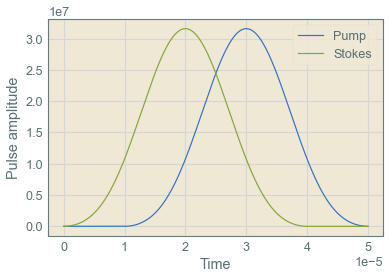

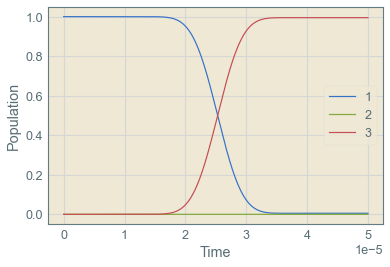

In [61]:
#Taking both as 31.6 MHz we can get effective rabi of approx 0.5 MHz with 1 GHz detuning
h = 6.626*(10**(-34))
hfs = 6.834673617*(10**9)
F_3 = 3.845*(10**14)
try_1 = STIRAP(True,31.6*10**6,31.6*10**6,0,hfs,F_3,5*10**(-5),4*10**(-5),1*10**(-5),10**9)
try_1.plot_pulse()
try_1.final_plot()

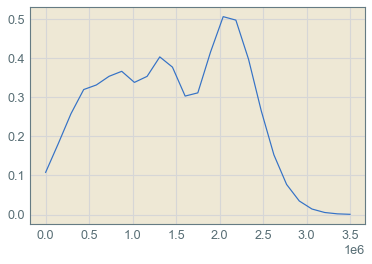

In [91]:
#Dependency of efficiency on delta for unequal rabi frequencies
deltas = np.linspace(0,0.35*10**7,25)
effi_d = []
for d in deltas:
    trial = STIRAP(True,100*10**6,10*10**6,0,hfs,F_3,5*10**(-5),4*10**(-5),1*10**(-5),10**9,0,d)
    _,e = trial.final_result()
    effi_d.append(e)
plt.plot(deltas,effi_d)

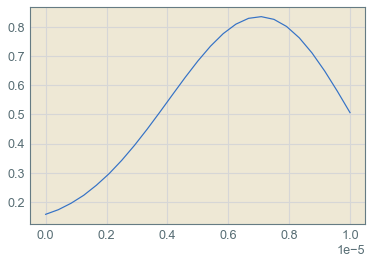

In [92]:
#Dependency of efficiency on delta for unequal rabi frequencies
overlaps = np.linspace(0,1*10**(-5),100)
effi_o = []
for o in overlaps:
    trial = STIRAP(True,100*10**6,10*10**6,0,hfs,F_3,5*10**(-5),5*10**(-5)-o,o,10**9,0,deltas[effi_d.index(max(effi_d))])
    _,e = trial.final_result()
    effi_o.append(e)
plt.plot(overlaps,effi_o)

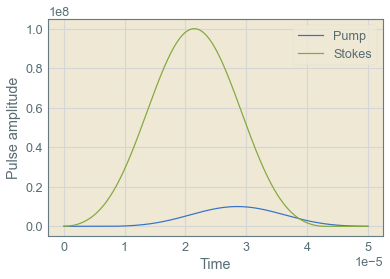

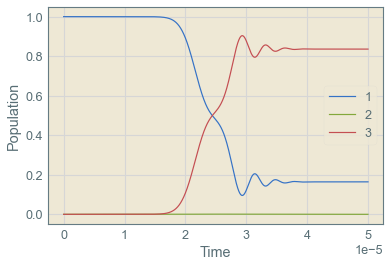

In [95]:
try_2 = STIRAP(True,100*10**6,10*10**6,0,hfs,F_3,5*10**(-5),5*10**(-5)-overlaps[effi_o.index(max(effi_o))],overlaps[effi_o.index(max(effi_o))],10**9,0,deltas[effi_d.index(max(effi_d))])
try_2.plot_pulse()
try_2.final_plot()